# Stats on predictions

# table of content
1) [Load stats](#load-stats)
2) [Show histograms and barplots](#show-histograms-and-barplots)
3) [Pie on heights](#pie-on-heights)

### Dependencies and general utils

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import laspy
import pdal
import json
from tqdm import tqdm

In [25]:
# src folder
files_src = r"..\data\testing_samples\split_0332_out_split_instance"
files = [x for x in os.listdir(files_src) if x.endswith('.laz')]
print(files[2])
        

split_0332_out_10.laz


### Load stats

In [34]:
# get the different stats points
dict_stats = {
    "count": [],
    "min": [],
    "max": [],
    "height": [],
    "std": [],
    "var": [],
}
for _, file in tqdm(enumerate(files), total=len(files)):
    if _ == 0: # skip the ground
        continue

    # load file's stats
    pipeline_json = {
            "pipeline": [
                os.path.join(files_src, file),
                {
                    "type": "filters.stats"
                }
            ]
        }
    pipeline = pdal.Pipeline(json.dumps(pipeline_json))
    pipeline.execute()

    # record stats
    stats = pipeline.metadata['metadata']["filters.stats"]["statistic"][0]
    dict_stats['count'].append(stats['count'])
    dict_stats['min'].append(stats['minimum'])
    dict_stats['max'].append(stats['maximum'])
    dict_stats['height'].append(stats['maximum'] - stats['minimum'])
    dict_stats['std'].append(stats['stddev'])
    dict_stats['var'].append(stats['variance'])

    # for stat, stat_val in pipeline.metadata['metadata']["filters.stats"]["statistic"][0].items():
    #     print(f"{stat}: {stat_val}")

100%|██████████| 284/284 [00:01<00:00, 150.62it/s]


### Show histograms and barplots

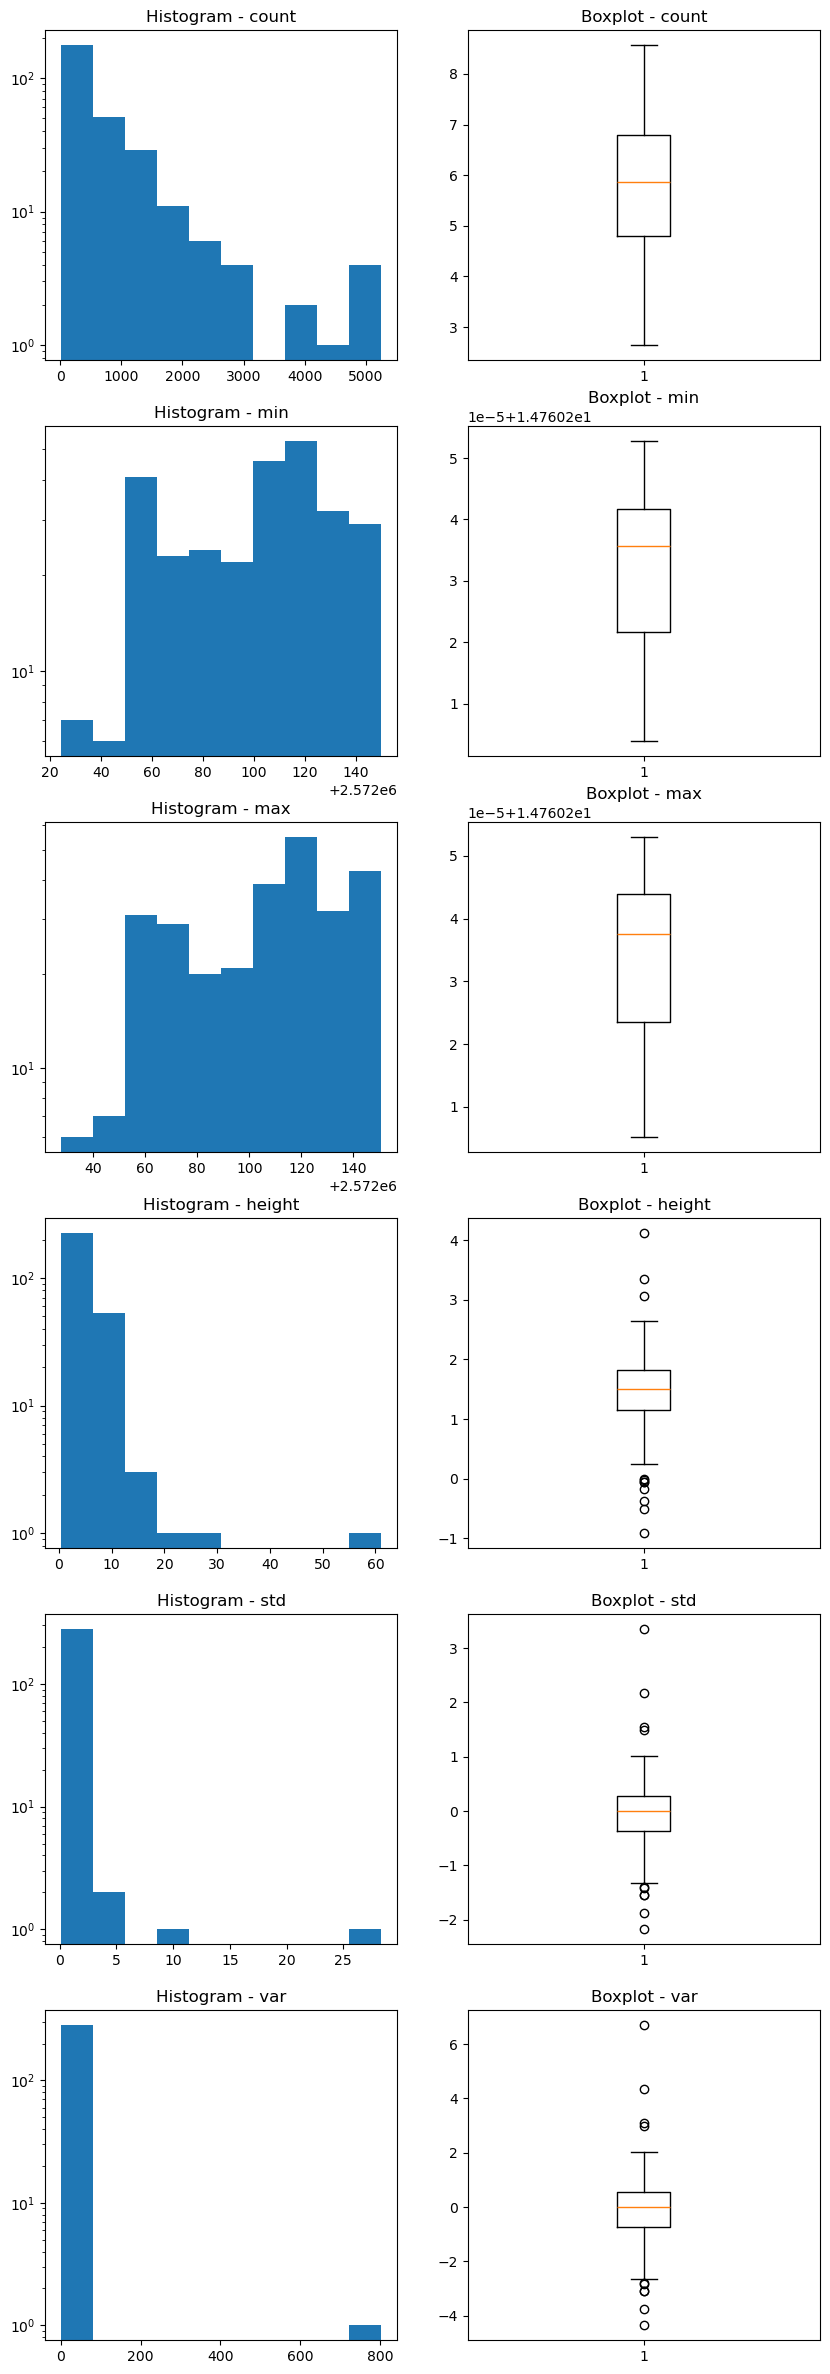

In [90]:
fig, axs = plt.subplots(len(dict_stats), 2, figsize=(10,30))
for idx, (stat, stat_vals) in enumerate(dict_stats.items()):
    axs[idx, 0].hist(stat_vals, log=True)
    axs[idx, 1].boxplot(np.log(stat_vals))
    axs[idx, 0].set_title(f'Histogram - {stat}')
    axs[idx, 1].set_title(f'Boxplot - {stat}')
plt.show()

### Pie on heights

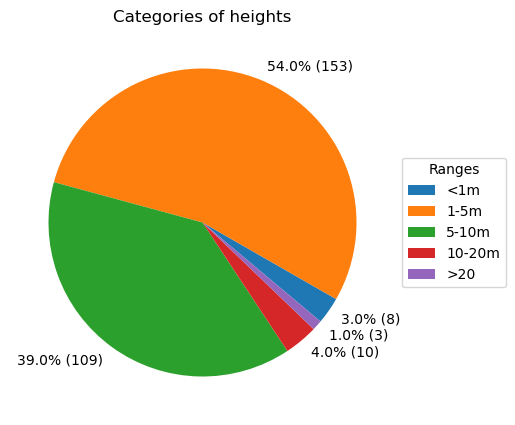

In [83]:
# categories
list_height = [0, 1, 5, 10, 20, np.inf]
labels_height = ['<1m', '1-5m', '5-10m', '10-20m', '>20']
list_count = []
for i in range(5):
    list_count.append(len([x for x in dict_stats['height'] if x > list_height[i] and x < list_height[i+1]]))


def func(pct, allvals):
    frac = int(np.round(pct/np.sum(allvals)*100))
    return f"{frac:.1f}% ({pct:d})"
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(list_count, startangle=-40, labels=[func(x, list_count) for x in list_count])
ax.legend(wedges, labels_height,
          title="Ranges",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Categories of heights")

plt.show()